<a href="https://colab.research.google.com/github/asgharlaib/Project_v1/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing Neccessary Packages

In [1]:
pip install --upgrade adapt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 99.6 MB/s eta 0:00:00
  Created wheel for adapt: filename=adapt-0.4.4-py3-none-any.whl size=131790 sha256=df1d0d1e9e43e1be04f56a10bca90da35f5df83e05f5dc8beef359881c9f176d
  Stored in directory: /root/.cache/pip/wheels/cb/88/91/f7ac7b6024ad8778b5ecca6ebe44421105722648f2a6b7afd7
Successfully built adapt
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2


In [2]:
pip install keras --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 41.6 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1


In [3]:
!pip install prophet

Importing necessary libraries

In [4]:
#Importing necessary libraries
import pandas as pd
import scikeras
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, make_scorer
from sklearn.model_selection import GridSearchCV
from prophet import Prophet
from scikeras.wrappers import KerasRegressor
import os
import xgboost as xgb

Data PreProcessing


reading the data


In [5]:
#Importing the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#reading the dataset
full_df = pd.read_csv("/content/drive/MyDrive/LCL-June2015v2_134.csv")
full_df.head(n=10)

,LCLid,stdorToU,DateTime,KWH/hh (per half hour)
0,MAC005555,Std,2012-06-15 03:30:00.0000000,0.118
1,MAC005555,Std,2012-06-15 04:00:00.0000000,0.078
2,MAC005555,Std,2012-06-15 04:30:00.0000000,0.091
3,MAC005555,Std,2012-06-15 05:00:00.0000000,0.068
4,MAC005555,Std,2012-06-15 05:30:00.0000000,0.092
5,MAC005555,Std,2012-06-15 06:00:00.0000000,0.194
6,MAC005555,Std,2012-06-15 06:30:00.0000000,0.091
7,MAC005555,Std,2012-06-15 07:00:00.0000000,0.069
8,MAC005555,Std,2012-06-15 07:30:00.0000000,0.088
9,MAC005555,Std,2012-06-15 08:00:00.0000000,0.087


In [7]:
#Making copy of origonal dataset
full_df_copy = full_df.copy()

In [8]:
#Looking for columns datatypes to perform operations
print(f"full_df columns datatypes: {full_df.dtypes}")

full_df columns datatypes: LCLid                      object
stdorToU                   object
DateTime                   object
KWH/hh (per half hour)     object
dtype: object


In [9]:
# Convert the 'DateTime' column to datetime type
full_df['DateTime'] = pd.to_datetime(full_df['DateTime'])


# Extract the date and time into separate columns
full_df['Date'] = full_df['DateTime'].dt.date
full_df['Time'] = full_df['DateTime'].dt.time


# Display the first few rows to verify
print(full_df.head())

       LCLid stdorToU            DateTime KWH/hh (per half hour)         Date  \
0  MAC005555      Std 2012-06-15 03:30:00                  0.118   2012-06-15   
1  MAC005555      Std 2012-06-15 04:00:00                  0.078   2012-06-15   
2  MAC005555      Std 2012-06-15 04:30:00                  0.091   2012-06-15   
3  MAC005555      Std 2012-06-15 05:00:00                  0.068   2012-06-15   
4  MAC005555      Std 2012-06-15 05:30:00                  0.092   2012-06-15   

       Time  
0  03:30:00  
1  04:00:00  
2  04:30:00  
3  05:00:00  
4  05:30:00  


In [10]:
#Setting DateTime to index
full_df.set_index('DateTime', inplace=True)

In [11]:
#Converting consumption column to numeric datatype
full_df['KWH/hh (per half hour) '] = pd.to_numeric(full_df['KWH/hh (per half hour) '], errors='coerce')
full_df.columns

Index(['LCLid', 'stdorToU', 'KWH/hh (per half hour) ', 'Date', 'Time'], dtype='object')

In [12]:
#Pre-processing for creating daily dataframe
full_df_daily = full_df.groupby(['LCLid','stdorToU', 'Date']).agg({'KWH/hh (per half hour) ': 'sum'}).reset_index()
full_df_daily.rename(columns={'KWH/hh (per half hour) ': 'Daily KWH'}, inplace=True)
full_df_daily.head(20)

,LCLid,stdorToU,Date,Daily KWH
0,MAC000005,ToU,2012-06-01,2.866
1,MAC000005,ToU,2012-06-02,4.790
2,MAC000005,ToU,2012-06-03,5.447
3,MAC000005,ToU,2012-06-04,6.703
4,MAC000005,ToU,2012-06-05,5.056
5,MAC000005,ToU,2012-06-06,3.663
6,MAC000005,ToU,2012-06-07,3.863
7,MAC000005,ToU,2012-06-08,3.935
8,MAC000005,ToU,2012-06-09,2.612
9,MAC000005,ToU,2012-06-10,3.208


Handling Outliers and Missing Values


In [13]:
#Locating nan indices
nan_indices = full_df_daily[full_df_daily['Daily KWH'].isnull()].index
print(nan_indices)

Index([], dtype='int64')


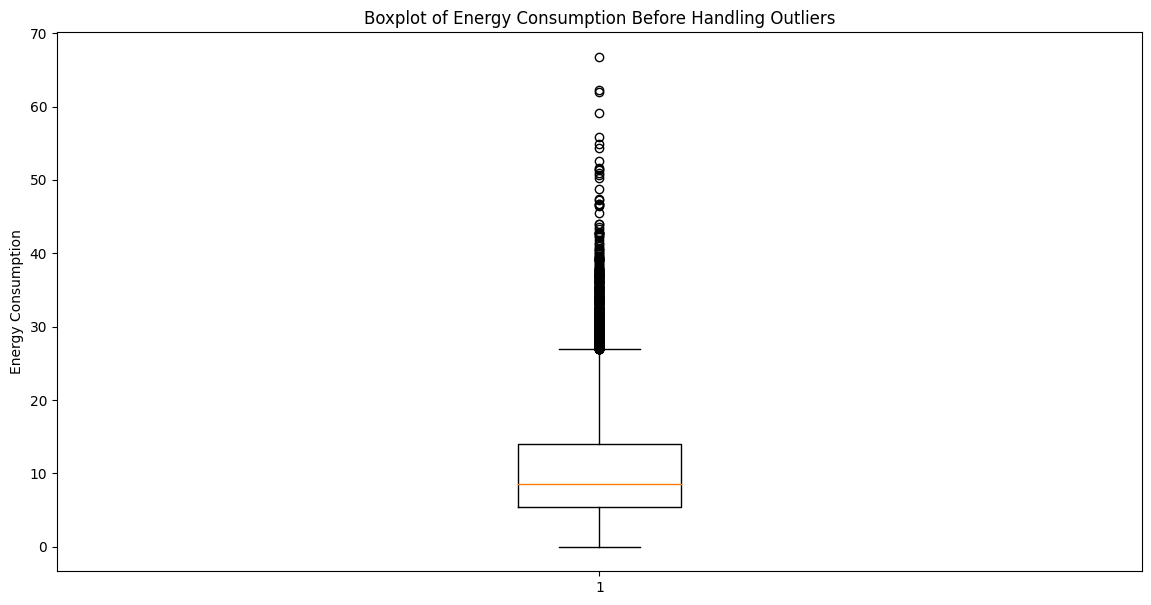

In [14]:
#Visualzing data for outliers
plt.figure(figsize=(14, 7))

plt.boxplot(full_df_daily['Daily KWH'])
plt.title('Boxplot of Energy Consumption Before Handling Outliers')
plt.ylabel('Energy Consumption')
plt.savefig('Outliers_Boxplot before.png')
plt.show()

In [15]:
#Setting upper and lower bounds using IQR
Q1 = full_df_daily['Daily KWH'].quantile(0.25)
Q3 = full_df_daily['Daily KWH'].quantile(0.75)
IQR = Q3 - Q1
lower_th = Q1 - 1.5 * IQR
upper_th = Q3 + 1.5 * IQR

In [18]:
#Filtering outliers
cleaned_data = full_df_daily[(full_df_daily['Daily KWH'] >= lower_th) &
                              (full_df_daily['Daily KWH'] <= upper_th)]
cleaned_data.head(-10)

,LCLid,stdorToU,Date,Daily KWH
0,MAC000005,ToU,2012-06-01,2.866
1,MAC000005,ToU,2012-06-02,4.790
2,MAC000005,ToU,2012-06-03,5.447
3,MAC000005,ToU,2012-06-04,6.703
4,MAC000005,ToU,2012-06-05,5.056
...,...,...,...,...
20861,MAC005567,Std,2014-02-14,5.364
20862,MAC005567,Std,2014-02-15,7.075
20863,MAC005567,Std,2014-02-16,6.727
20864,MAC005567,Std,2014-02-17,6.593


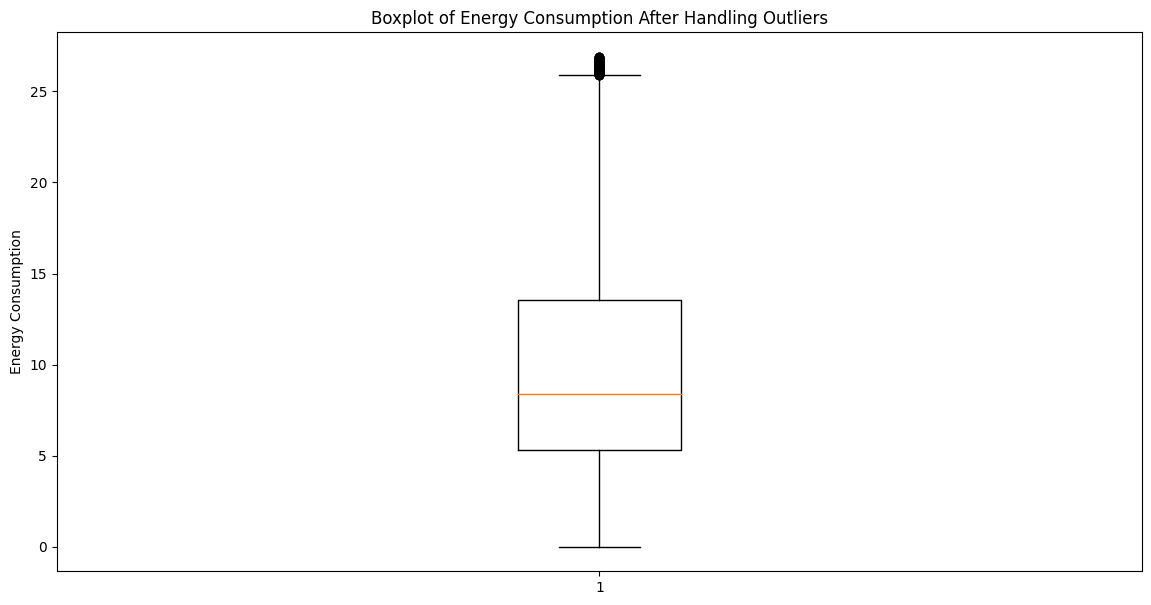

In [21]:
#Boxplot after handling outliers
plt.figure(figsize=(14, 7))

plt.boxplot(cleaned_data['Daily KWH'])
plt.title('Boxplot of Energy Consumption After Handling Outliers')
plt.ylabel('Energy Consumption')
plt.savefig('Outliers_Subplot after.png')
plt.show()



In [22]:
#Looking for missing values
print(f"missing values: {full_df_daily.isnull().sum()} \n")

missing values: LCLid        0
stdorToU     0
Date         0
Daily KWH    0
dtype: int64 



# Explanatory Data Analysis


In [23]:
##Descriptive Analysis
#Dataframe column names
print(f"Column names: {list(full_df_daily.columns)} \n")

#Dataframe shape
print(f"full_df_daily shape: {full_df_daily.shape} \n")

#Dataframe datatypes
print(f"full_df_daily columns datatypes: {full_df_daily.dtypes} \n")

#Looking for missing values
print(f"missing values: {full_df_daily.isnull().sum()} \n")

Column names: ['LCLid', 'stdorToU', 'Date', 'Daily KWH'] 

full_df_daily shape: (20876, 4) 

full_df_daily columns datatypes: LCLid         object
stdorToU      object
Date          object
Daily KWH    float64
dtype: object 

missing values: LCLid        0
stdorToU     0
Date         0
Daily KWH    0
dtype: int64 



In [24]:
##Descriptive Statistics
full_df_daily.describe()

,Daily KWH
count,20876.000000
mean,10.420657
std,6.714300
min,0.000000
25%,5.385000
50%,8.580000
75%,13.991000
max,66.782000


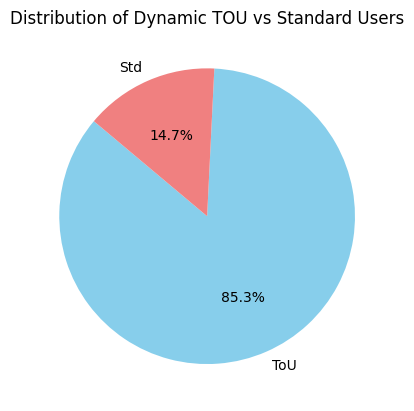

In [26]:
# Count the occurrences of each category
counts = cleaned_data['stdorToU'].value_counts()

# Plot a pie chart
plt.figure()
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightcoral'])
plt.title('Distribution of Dynamic TOU vs Standard Users')
plt.savefig('piechart.png')
plt.show()


           LCLid stdorToU        Date  Daily KWH
17764  MAC005555      Std  2012-06-15      4.251
17765  MAC005555      Std  2012-06-16      5.190
17766  MAC005555      Std  2012-06-17      4.720
17767  MAC005555      Std  2012-06-18      6.311
17768  MAC005555      Std  2012-06-19      5.720
       LCLid stdorToU        Date  Daily KWH
0  MAC000005      ToU  2012-06-01      2.866
1  MAC000005      ToU  2012-06-02      4.790
2  MAC000005      ToU  2012-06-03      5.447
3  MAC000005      ToU  2012-06-04      6.703
4  MAC000005      ToU  2012-06-05      5.056


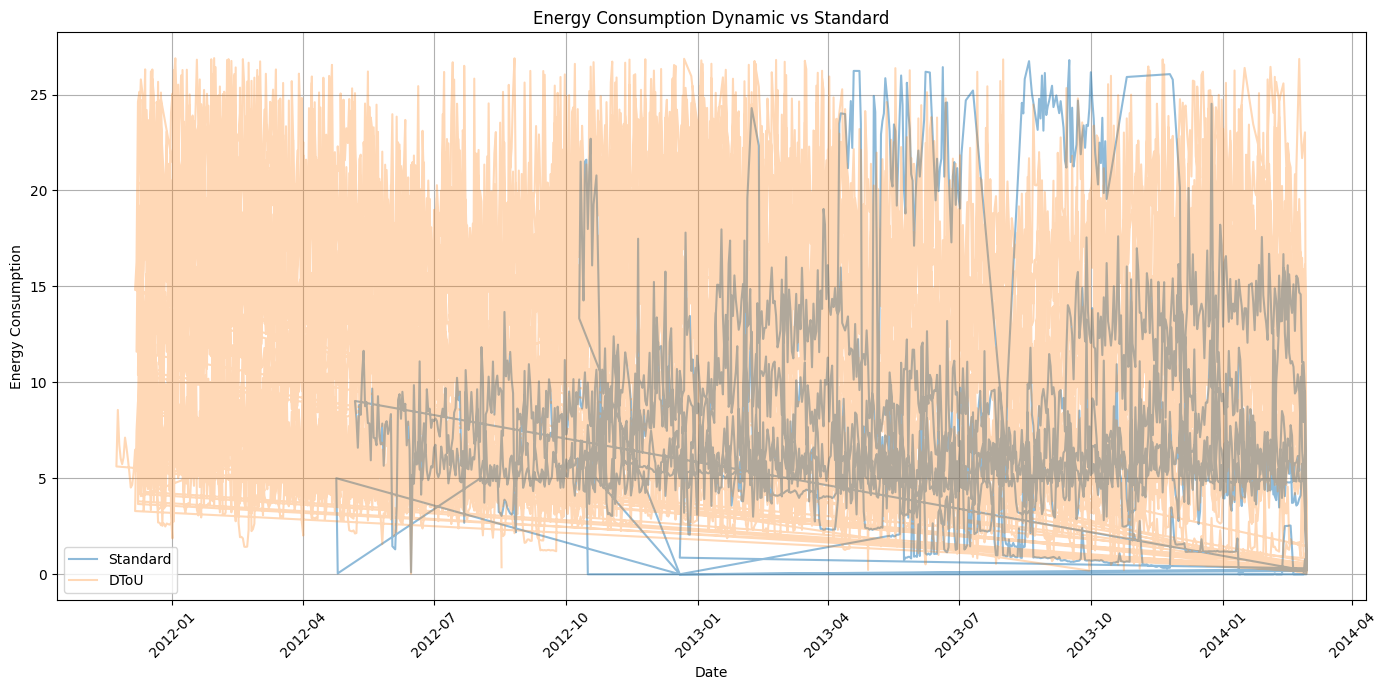

In [27]:
# Filter for dynamic and standard pricing
df_standard = cleaned_data[cleaned_data['stdorToU'] == 'Std']
df_dynamic = cleaned_data[cleaned_data['stdorToU'] == 'ToU']

print(df_standard.head())
print(df_dynamic.head())
# Plot the data
plt.figure(figsize=(14, 7))
plt.plot(df_standard['Date'], df_standard['Daily KWH'],alpha = 0.5, label='Standard')
plt.plot(df_dynamic['Date'], df_dynamic['Daily KWH'],alpha= 0.3, label='DToU')
# Formatting the plot
plt.title('Energy Consumption Dynamic vs Standard')
plt.xlabel('Date')
plt.ylabel('Energy Consumption')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig('Energy_Consumption_Dynamic_vs_Standard.png')

# Show the plot
plt.show()


# Model Training and Evaluation

Prophet

Training

In [28]:
#Converting dynamic dataset in a format suitable for prophet model
df_prophet_dynamic = df_dynamic[['Date', 'Daily KWH']].rename(columns={'Date': 'ds', 'Daily KWH': 'y'})

In [29]:
#Splitting data into train and test
train_size_dynamic = int(len(df_prophet_dynamic) * 0.8)
train_data_dynamic = df_prophet_dynamic[:train_size_dynamic]
test_data_dynamic = df_prophet_dynamic[train_size_dynamic:]

In [30]:
#fitting model
model_dynamic = Prophet()
model_dynamic.fit(train_data_dynamic)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxi1zly44/pie4g20q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxi1zly44/_brjm0_x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54550', 'data', 'file=/tmp/tmpxi1zly44/pie4g20q.json', 'init=/tmp/tmpxi1zly44/_brjm0_x.json', 'output', 'file=/tmp/tmpxi1zly44/prophet_modeltonsqt3m/prophet_model-20240830194408.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:44:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:44:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [38]:
#Forecasting
future_dynamic = model_dynamic.make_future_dataframe(periods=len(test_data_dynamic), freq='D')  # 'D' for daily data
forecast_dynamic = model_dynamic.predict(future_dynamic)
forecast_test_dynamic = forecast_dynamic.iloc[-len(test_data_dynamic):]['yhat']

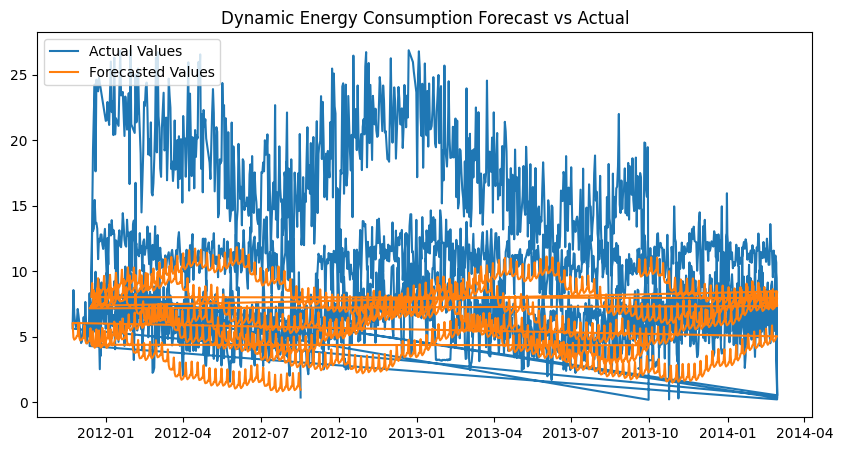

In [39]:
#Plotting Actual vs Predicted values
plt.figure(figsize=(10, 5))
plt.plot(test_data_dynamic['ds'], test_data_dynamic['y'], label='Actual Values')
plt.plot(test_data_dynamic['ds'], forecast_test_dynamic, label='Forecasted Values')
plt.legend(loc='upper left')
plt.title('Dynamic Energy Consumption Forecast vs Actual')
plt.savefig('Dynamic_Peak_Hour_Forecast_vs_Actual.png')
plt.show()

In [ ]:
#Converting standard dataframe in format suitable for prophet model
df_prophet_std = df_standard[['Date', 'Daily KWH']].rename(columns={'Date': 'ds', 'Daily KWH': 'y'})

In [ ]:
#Splitting data in train and test datasets
train_size_std = int(len(df_prophet_std) * 0.8)
train_data_std = df_prophet_std[:train_size_std]
test_data_std = df_prophet_std[train_size_std:]
print(test_data_std)

In [ ]:
#Training
model_std = Prophet()
model_std.fit(train_data_std)

In [ ]:
#Forecasting
future_std = model_std.make_future_dataframe(periods=len(test_data_std), freq='D')  # 'D' for daily data
forecast_std = model_std.predict(future_std)

Evaluation

In [ ]:
#Evaluating model performance
forecast_test_std = forecast_std.iloc[-len(test_data_std):]['yhat']

mse_std = mean_squared_error(test_data_std['y'], forecast_test_std)
mae_std = mean_absolute_error(test_data_std['y'], forecast_test_std)
rmse_std = np.sqrt(mse_std)


print(f'Mean Squared Error: {mse_std}')
print(f'Mean Absolute Error: {mae_std}')
print(f'Root Mean Squared Error: {rmse_std}')

In [ ]:
#Evaluating model performance

mse_dynamic = mean_squared_error(test_data_dynamic['y'], forecast_test_dynamic)
mae_dynamic = mean_absolute_error(test_data_dynamic['y'], forecast_test_dynamic)
rmse_dynamic = np.sqrt(mse_dynamic)


print(f'Mean Squared Error: {mse_dynamic}')
print(f'Mean Absolute Error: {mae_dynamic}')
print(f'Root Mean Squared Error: {rmse_dynamic}')

In [ ]:
#plotting original vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(test_data_std['ds'], test_data_std['y'], label='Actual Values')
plt.plot(test_data_std['ds'], forecast_test_std, label='Forecasted Values')
plt.legend(loc='upper left')
plt.title('Standard Energy Consumption Forecast vs Actual')
plt.savefig('Standard_Peak_Hour_Prophet_Forecast_vs_Actual.png')
plt.show()

In [ ]:
# Find the maximum predicted consumption
max_predicted_value = forecast_dynamic['yhat'].max()
max_predicted_value = forecast_std['yhat'].max()

# Print the results
print(f"The maximum predicted dynamic consumption is {max_predicted_value:.1f} KWH")
print(f"The maximum predicted standard consumption is {max_predicted_value:.1f} KWH")

Optimization

In [ ]:
#Defining custom optimizer
import itertools

# Define the parameter grid
param_grid = {
    'changepoint_prior_scale': [0.01, 0.1, 0.5],
    'seasonality_prior_scale': [10.0, 15.0, 20.0],
    'holidays_prior_scale': [0.1, 0.5, 1.0]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

# Initialize a DataFrame to store the results
results = []

# Loop over each combination of parameters
for params in all_params:
    # Initialize a Prophet model with the current set of parameters
    model = Prophet(
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        holidays_prior_scale=params['holidays_prior_scale'],
        daily_seasonality=True,
        yearly_seasonality=True,
        weekly_seasonality=True
    )

     # Fit the model on the training data
    model.fit(train_data_dynamic)

    # Make predictions on the test data
    forecast = model.predict(test_data_dynamic)

    # Calculate the mean absolute error of the predictions
    mae = mean_absolute_error(test_data_dynamic['y'], forecast['yhat'])

    # Store the parameters and the mse in the results list
    results.append({'params': params, 'mae': mae})

# Convert the results list into a DataFrame
results_df = pd.DataFrame(results)

# Find the parameters with the lowest mae
best_params = results_df.loc[results_df['mae'].idxmin()]

print(f"Best Parameters: {best_params['params']}")
print(f"Best MAE: {best_params['mae']}")

In [ ]:
#Optimization for standard dataset
#Define the parameter grid
param_grid = {
    'changepoint_prior_scale': [0.01, 0.1, 0.5],
    'seasonality_prior_scale': [10.0, 15.0, 20.0],
    'holidays_prior_scale': [0.1, 0.5, 1.0],
    'yearly_seasonality': [True, False]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

# Initialize a DataFrame to store the results
results = []

# Loop over each combination of parameters
for params in all_params:
    # Initialize a Prophet model with the current set of parameters
    model = Prophet(
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        holidays_prior_scale=params['holidays_prior_scale'],
        yearly_seasonality=params['yearly_seasonality'],
        daily_seasonality=True,
        weekly_seasonality=True

    )

    # Fit the model on the training data
    model.fit(train_data_dynamic)

    # Make predictions on the test data
    forecast = model.predict(test_data_dynamic)

    # Calculate the mean squared error of the predictions
    mae = mean_absolute_error(test_data_dynamic['y'], forecast['yhat'])

    # Store the parameters and the mse in the results list
    results.append({'params': params, 'mae': mae})

# Convert the results list into a DataFrame
results_df = pd.DataFrame(results)

# Find the parameters with the lowest mae
best_params = results_df.loc[results_df['mae'].idxmin()]

print(f"Best Parameters: {best_params['params']}")
print(f"Best MAE: {best_params['mae']}")


In [ ]:
# Using the best parameters to fit the final model
best_model_dynamic = Prophet(
    changepoint_prior_scale=best_params['params']['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['params']['seasonality_prior_scale'],
    holidays_prior_scale=best_params['params']['holidays_prior_scale'],
    yearly_seasonality=best_params['params']['yearly_seasonality']
)

#Training and forecasting
best_model_dynamic.fit(train_data_dynamic)
best_forecast_dynamic = best_model_dynamic.predict(test_data_dynamic)

#Evaluating the forecast
best_forecast_test_dynamic = best_forecast_dynamic.iloc[-len(test_data_dynamic):]['yhat']
mse_dyn_opt = mean_squared_error(test_data_dynamic['y'], best_forecast_test_dynamic)
mae_dyn_opt = mean_absolute_error(test_data_dynamic['y'], best_forecast_test_dynamic)
rmse_dyn_opt = np.sqrt(mse_dyn_opt)


print(f'Mean Squared Error: {mse_dyn_opt}')
print(f'Mean Absolute Error: {mae_dyn_opt}')
print(f'Root Mean Squared Error: {rmse_dyn_opt}')

In [ ]:
#Visualize actual vs. predicted dynamic
plt.figure(figsize=(10, 5))
plt.plot(test_data_dynamic['ds'], test_data_dynamic['y'], label='Actual Values')
plt.plot(test_data_dynamic['ds'], best_forecast_test_dynamic, label='Forecasted Values')
plt.legend(loc='upper left')
plt.title('Dynamic Energy Consumption Forecast vs Actual Optimised Model')
plt.savefig('Dynamic_Peak_Hour_Prophet_Forecast_vs_Actual_Optimised_Model.png')
plt.show()

In [ ]:
# Find the maximum predicted consumption
max_predicted_value_std = best_forecast_std['yhat'].max()
max_predicted_value_dynamic = best_forecast_dynamic['yhat'].max()

# Print the results
print(f"The maximum predicted standard consumption is {max_predicted_value_std:.2f} KWH")
print(f"The maximum predicted dynamic consumption is {max_predicted_value_dynamic:.2f} KWH")

In [ ]:
# Using the best parameters to fit the final model
best_model_std = Prophet(
    changepoint_prior_scale=best_params['params']['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['params']['seasonality_prior_scale'],
    holidays_prior_scale=best_params['params']['holidays_prior_scale'],
    yearly_seasonality=best_params['params']['yearly_seasonality']
)

#traing and forecasting
best_model_std.fit(train_data_std)
best_forecast_std = best_model_std.predict(test_data_std)

#Evaluate the forecast
best_forecast_test_std = best_forecast_std.iloc[-len(test_data_std):]['yhat']
mse_std_opt = mean_squared_error(test_data_std['y'], best_forecast_test_std)
mae_std_opt = mean_absolute_error(test_data_std['y'], best_forecast_test_std)
rmse_std_opt = np.sqrt(mse_std_opt)
print(f'Mean Squared Error: {mse_std_opt}')
print(f'Mean Absolute Error: {mae_std_opt}')
print(f'Root Mean Squared Error: {rmse_std_opt}')

In [ ]:
#Visualize the actual vs predicted standard
plt.figure(figsize=(10, 5))
plt.plot(test_data_std['ds'], test_data_std['y'], label='Actual Values')
plt.plot(test_data_std['ds'], best_forecast_test_std, label='Forecasted Values')
plt.legend(loc='upper left')
plt.title('Standard Energy Consumption Forecast vs Actual Optimised Model')
plt.savefig('Standard_Peak_Hour_Prophet_Forecast_vs_Actual_Optimised_Model.png')
plt.show()

XGBoost

In [ ]:
#Creating lagged data for XGBoost
def create_lag_data(df, time_steps):

    data = df['Daily KWH'].values
    X, y = [], []

    # Generate lag data
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i])
        y.append(data[i])

    X = np.array(X)
    y = np.array(y)

    return X, y


In [ ]:
#Preprocessing data for XGBoost
time_steps = 8  # Use the previous 8 days to predict the next day's consumption
X_dynamic, y_dynamic = create_lag_features(df_dynamic, time_steps)
X_standard, y_standard = create_lag_features(df_standard, time_steps)

In [ ]:
# Split the data
X_train_dyn, X_test_dyn, y_train_dyn, y_test_dyn = train_test_split(X_dynamic, y_dynamic, test_size=0.2, random_state=42)

# If necessary, reshape the data
X_train_dyn = X_train_dyn.reshape((X_train_dyn.shape[0], X_train_dyn.shape[1]))
X_test_dyn = X_test_dyn.reshape((X_test_dyn.shape[0], X_test_dyn.shape[1]))

In [ ]:
# Split the data
X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(X_standard, y_standard, test_size=0.2, random_state=42)

# Reshape the data
X_train_std = X_train_std.reshape((X_train_std.shape[0], X_train_std.shape[1]))
X_test_std = X_test_std.reshape((X_test_std.shape[0], X_test_std.shape[1]))

In [ ]:

# Initialize the model
xgb_dyn = xgb.XGBRegressor(objective='reg:squarederror')

# Train the model
xgb_dyn.fit(X_train_dyn, y_train_dyn)

# Make predictions
y_pred_dyn = xgb_dyn.predict(X_test_dyn)


Evaluating Dynamic Dataset

In [ ]:
# Calculate metrics
mse_dyn = mean_squared_error(y_test_dyn, y_pred_dyn)
mae_dyn = mean_absolute_error(y_test_dyn, y_pred_dyn)
rmse_dyn = np.sqrt(mse_dyn)

print(f'MSE: {mse_dyn}, MAE: {mae_dyn}, RMSE: {rmse_dyn}')

In [ ]:
#Plotting Actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test_dyn, label='Actual', color='blue')
plt.plot(y_pred_dyn, label='Predicted', color='orange')
plt.title('Actual vs Predicted Energy Consumption')
plt.xlabel('Time')
plt.ylabel('Daily KWH')
plt.legend()
plt.savefig('xgboost_actual_vs_predicted_dynamic_energy_consumption.png')
plt.show()


In [ ]:

# Initialize the model for standard dataset
xgb_std = xgb.XGBRegressor(objective='reg:squarederror')

# Train the model
xgb_std.fit(X_train_std, y_train_std)

# Make predictions
y_pred_std = xgb_std.predict(X_test_std)


Evaluating for standard dataset

In [ ]:
# Calculate metrics
mse_std = mean_squared_error(y_test_std, y_pred_std)
mae_std = mean_absolute_error(y_test_std, y_pred_std)
rmse_std = np.sqrt(mse_std)

print(f'MSE: {mse_std}, MAE: {mae_std}, RMSE: {rmse_std}')

In [ ]:
#Actual vs predicted values standard
plt.figure(figsize=(14, 7))
plt.plot(y_test_std, label='Actual', color='blue')
plt.plot(y_pred_std, label='Predicted', color='orange')
plt.title('Actual vs Predicted Energy Consumption')
plt.xlabel('Time')
plt.ylabel('Daily KWH')
plt.legend()
plt.savefig('xgboost_actual_vs_predicted_std_energy_consumption.png')
plt.show()

Optimization

In [ ]:
# Initialize XGBoost regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

In [ ]:
# Initialize GridSearchCV with 5-fold cross-validation
grid_search_dynamic = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# Fit the grid search
grid_search_dynamic.fit(X_train_dyn, y_train_dyn)

# Get the best parameters and best model
best_params_dyn = grid_search_dynamic.best_params_
best_model_dyn = grid_search_dynamic.best_estimator_

print(f"Best Parameters Dynamic: {best_params_dyn}")

In [ ]:
# Make predictions on the test set
y_pred_dyn_opt = best_model_dyn.predict(X_test_dyn)

In [ ]:
#Evaluating best fit
mae_dynamic_opt = mean_absolute_error(y_test_dyn, y_pred_dyn_opt)
mse_dynamic_opt = mean_squared_error(y_test_dyn, y_pred_dyn_opt)
rmse_dynamic_opt = np.sqrt(mse_dynamic_opt)

print(f"Dynamic TOU MAE: {mae_dynamic_opt}")
print(f"Dynamic TOU MSE: {mse_dynamic_opt}")
print(f"Dynamic TOU RMSE: {rmse_dynamic_opt}")

In [ ]:
# Create a plot of Actual vs predicted value
plt.figure(figsize=(10, 6))

# Plot actual values
plt.plot(y_test_dyn, label='Actual', color='blue')

# Plot predicted values
plt.plot(y_pred_dyn_opt, label='Predicted', color='red')

# Adding title and labels
plt.title('Optimized Actual vs Predicted Energy Consumption')
plt.xlabel('Time')
plt.ylabel('KWH/hh (per half hour)')
plt.legend()
plt.savefig('opt_xgboost_dynamic_actual_vs_predicted.png')

# Display the plot
plt.show()

In [ ]:
# Find the peak consumption value

peak_consumption_dynamic = np.max(y_pred_dyn)

print(f"Peak consumption dynamic: {peak_consumption_dynamic}")
peak_consumption_std = np.max(y_pred_std)

print(f"Peak consumption Standard: {peak_consumption_std}")

In [ ]:
# Initialize GridSearchCV with 5-fold cross-validation and error handling
grid_search_std = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, error_score='raise') # Setting error_score='raise' will help pinpoint the exact location of the problematic values

# Fit the grid search
grid_search_std.fit(X_train_std, y_train_std)

# Get the best parameters and best model
best_params_std = grid_search_std.best_params_
best_model_std = grid_search_std.best_estimator_

print(f"Best Parameters Dynamic: {best_params_std}")


In [ ]:
# Make predictions on the test set
y_pred_std_opt = best_model_std.predict(X_test_std)

In [ ]:
#Evaluating best fit
mae_std_opt = mean_absolute_error(y_test_std, y_pred_std_opt)
mse_std_opt = mean_squared_error(y_test_std, y_pred_std_opt)
rmse_std_opt = np.sqrt(mse_std_opt)

print(f"Dynamic TOU MAE: {mae_std_opt}")
print(f"Dynamic TOU MSE: {mse_std_opt}")
print(f"Dynamic TOU RMSE: {rmse_std_opt}")

In [ ]:
# Create a plot actual vs dynamic
plt.figure(figsize=(10, 6))

# Plot actual values
plt.plot(y_test_std, label='Actual', color='blue')

# Plot predicted values
plt.plot(y_pred_std_opt, label='Predicted', color='red')

# Adding title and labels
plt.title('Optimized Standard Actual vs Predicted Energy Consumption')
plt.xlabel('Time')
plt.ylabel('KWH/hh (per half hour)')
plt.legend()
plt.savefig('opt_xgboost_standard_actual_vs_predicted.png')

# Display the plot
plt.show()

In [ ]:
# Find the peak consumption value
peak_consumption_dynamic = np.max(y_pred_dyn_opt)

print(f"Peak consumption dynamic: {peak_consumption_dynamic}")
peak_consumption_std = np.max(y_pred_std_opt)

print(f"Peak consumption Standard: {peak_consumption_std}")


LSTM

In [ ]:
#Function to convert raw data in formsuitable for LSTM
def LSTM_preprocess_data(ds, time_step):
    data = ds['Daily KWH'].values
    dates = ds['Date'].values  # Using 'Date' column
    data = data.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data)

    X, y, datestamps = [], [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
        datestamps.append(dates[i + time_step])  # Store corresponding date
    X = np.array(X)
    y = np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    datestamps = np.array(datestamps)  # Convert list to numpy array
    return X, y, scaler, datestamps


In [ ]:
# Preprocess the data
time_step = 8  # number of previous timesteps to use for prediction
X_dynamic, y_dynamic, scaler_dynamic, date_stamps_dynamic = LSTM_preprocess_data(df_dynamic, time_step)
X_standard, y_standard, scaler_standard, date_stamps_standard = LSTM_preprocess_data(df_standard, time_step)

In [ ]:
# Split the data into training and testing sets
X_train_dyn, X_test_dyn, y_train_dyn, y_test_dyn = train_test_split(X_dynamic, y_dynamic, test_size=0.2, random_state=42)
X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(X_standard, y_standard, test_size=0.2, random_state=42)

In [ ]:
# Build LSTM model
def build_lstm_model(input_shape, units=50, dropout_rate=0.2, learning_rate=0.001):
    print(f"Building LSTM model with input shape: {input_shape}")
    model = Sequential()
    model.add(LSTM(units, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model


Training

In [ ]:
# Train the LSTM model for dynamic users
model_dynamic = build_lstm_model(input_shape=(X_train_dyn.shape[1], X_train_dyn.shape[2]))
history_dynamic = model_dynamic.fit(X_train_dyn, y_train_dyn, epochs=20, batch_size=32, validation_data=(X_test_dyn, y_test_dyn), verbose=1)


In [ ]:
# Train the LSTM model for standard users
model_standard = build_lstm_model(input_shape=(X_train_std.shape[1], X_train_std.shape[2]))
history_standard = model_standard.fit(X_train_std, y_train_std, epochs=20, batch_size=32, validation_data=(X_test_std, y_test_std), verbose=1)


In [ ]:
# Predict consumption for dynamic users
pred_dynamic = model_dynamic.predict(X_test_dyn)

# Predict consumption for standard users
pred_standard = model_standard.predict(X_test_std)

Evaluation

In [ ]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 6))

# Plot the training loss
plt.plot(history_dynamic.history['loss'], label='Training Loss')

# Plot the validation loss
plt.plot(history_dynamic.history['val_loss'], label='Validation Loss')

# Add a title and labels
plt.title('Dynamic Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Show the legend
plt.legend()
plt.savefig('Dynamic Loss before opt')

# Display the plot
plt.show()


In [ ]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 6))

# Plot the training loss
plt.plot(history_standard.history['loss'], label='Training Loss')

# Plot the validation loss
plt.plot(history_standard.history['val_loss'], label='Validation Loss')

# Add a title and labels
plt.title('Standard Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Show the legend
plt.legend()
#save the image
plt.savefig('Standard_Training_and_Validation_Loss_Over_Epochs.png')

# Display the plot
plt.show()


In [ ]:
# Inverse transform the predictions for dynamic users
pred_dynamic = scaler_dynamic.inverse_transform(pred_dynamic)
y_test_dyn_inverse = scaler_dynamic.inverse_transform(y_test_dyn.reshape(-1, 1))

# Inverse transform the predictions for standard users
pred_standard = scaler_standard.inverse_transform(pred_standard)
y_test_std_inverse = scaler_standard.inverse_transform(y_test_std.reshape(-1, 1))

In [ ]:
# Calculate MAE for dynamic users
mae_dynamic = mean_absolute_error(y_test_dyn_inverse, pred_dynamic)
mse_dynamic = mean_squared_error(y_test_dyn_inverse, pred_dynamic)
rmse_dynamic = np.sqrt(mse_dynamic)

print(f"Dynamic TOU MAE: {mae_dynamic}")
print(f"Dynamic TOU MSE: {mse_dynamic}")
print(f"Dynamic TOU RMSE: {rmse_dynamic}")

# Calculate MAE for standard users
mae_standard = mean_absolute_error(y_test_std_inverse, pred_standard)
mse_standard = mean_squared_error(y_test_std_inverse, pred_standard)
rmse_standard = np.sqrt(mse_standard)

print(f"Standard TOU MAE: {mae_standard}")
print(f"Standard TOU MSE: {mse_standard}")
print(f"Standard TOU RMSE: {rmse_standard}")


In [ ]:
# Plot the predictions vs actual values for dynamic TOU users
plt.figure(figsize=(14, 7))
plt.plot(y_test_dyn_inverse, color='black', label='Actual Values')
plt.plot(pred_dynamic, color='orange', label='Predicted Values')
plt.title('Dynamic TOU Consumption: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.legend()
plt.savefig('LSTM dynamic consumption')
plt.show()




In [ ]:
# Plot the predictions vs actual values for dynamic TOU users
plt.figure(figsize=(14, 7))
plt.plot(y_test_std_inverse, color='black', label='Actual Values')
plt.plot(pred_standard, color='red', label='Predicted Values')
plt.title('Standard TOU Consumption: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.legend()
plt.savefig('LSTM standard consumption')
plt.show()


Peak Consumption before Optimization


In [ ]:
# Find peak consumption values for dynamic users
peak_dynamic_value = max(pred_dynamic)
print(f"Peak Dynamic TOU Consumption Value: {peak_dynamic_value}")
# Find peak consumption values for standard users
peak_standard_value = max(pred_standard)
print(f"Peak Standard Consumption Value: {peak_standard_value}")

Optimization and Tuning of Hyperparameters

In [ ]:
model = KerasRegressor(build_fn=build_lstm_model, input_shape = (8,1), epochs=1, batch_size=32, verbose=0, dropout_rate=0.2, learning_rate=0.001, units=50)

In [ ]:
param_grid = {
    'units': [50, 100],
    'dropout_rate': [0.2, 0.3],
    'learning_rate': [0.001, 0.01],
    'batch_size': [32, 64],
    'epochs': [10, 20]
}

from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_absolute_error')
grid_result = grid.fit(X_train_dyn, y_train_dyn)

# Print the best parameters and score
print(f"Best parameters found: {grid_result.best_params_}")


In [ ]:
# Build LSTM model
def best_grid_lstm_model(input_shape, units=50, dropout_rate=0.3, learning_rate=0.001):
    print(f"Building LSTM model with input shape: {input_shape}")
    model = Sequential()
    model.add(LSTM(units, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

Training on optimized parameters

In [ ]:
best_model_dynamic = best_grid_lstm_model(input_shape=(X_train_dyn.shape[1], X_train_dyn.shape[2]))
history_best_dynamic = best_model_dynamic.fit(X_train_dyn, y_train_dyn, epochs=20, batch_size=32, validation_data=(X_test_dyn, y_test_dyn), verbose=1)

In [ ]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 6))

# Plot the training loss
plt.plot(history_best_dynamic.history['loss'], label='Training Loss')

# Plot the validation loss
plt.plot(history_best_dynamic.history['val_loss'], label='Validation Loss')

# Add a title and labels
plt.title('Optimised Dynamic Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Show the legend
plt.legend()

#save the image
plt.savefig('Dynamic_Loss_after_opt')

# Display the plot
plt.show()

In [ ]:
best_model_standard = best_grid_lstm_model(input_shape=(X_train_std.shape[1], X_train_std.shape[2]))
history_best_standard = best_model_standard.fit(X_train_std, y_train_std, epochs=20, batch_size=32, validation_data=(X_test_std, y_test_std), verbose=1)

In [ ]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 6))

# Plot the training loss
plt.plot(history_best_standard.history['loss'], label='Training Loss')

# Plot the validation loss
plt.plot(history_best_standard.history['val_loss'], label='Validation Loss')

# Add a title and labels
plt.title('Optimized Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Show the legend
plt.legend()

#save the image
plt.savefig('Standard_Loss_after_opt')

# Display the plot
plt.show()

In [ ]:
# Predict consumption for dynamic users
pred_dynamic1 = best_model_dynamic.predict(X_test_dyn)

# Predict consumption for standard users
pred_standard1 = best_model_standard.predict(X_test_std)

In [ ]:
# Inverse transform the predictions for dynamic users
pred_dynamic1 = scaler_dynamic.inverse_transform(pred_dynamic1)
y_test_dyn_inverse = scaler_dynamic.inverse_transform(y_test_dyn.reshape(-1, 1))

# Inverse transform the predictions for standard users
pred_standard1 = scaler_standard.inverse_transform(pred_standard1)
y_test_std_inverse = scaler_standard.inverse_transform(y_test_std.reshape(-1, 1))

Evaluation after optimization

In [ ]:
# Calculate MAE for dynamic users
mae_dynamic_opt = mean_absolute_error(y_test_dyn_inverse, pred_dynamic1)
mse_dynamic_opt = mean_squared_error(y_test_dyn_inverse, pred_dynamic1)
rmse_dynamic_opt = np.sqrt(mse_dynamic_opt)

print(f"Optimized Dynamic TOU MAE: {mae_dynamic_opt}")
print(f"Optimized Dynamic TOU MSE: {mse_dynamic_opt}")
print(f"Optimized Dynamic TOU RMSE: {rmse_dynamic_opt}")

# Calculate MAE for standard users
mae_standard_opt = mean_absolute_error(y_test_std_inverse, pred_standard1)
mse_standard_opt = mean_squared_error(y_test_std_inverse, pred_standard1)
rmse_standard_opt = np.sqrt(mse_standard_opt)

print(f"Optimized Standard TOU MAE: {mae_standard_opt}")
print(f"Optimized Standard TOU MSE: {mse_standard_opt}")
print(f"Optimized Standard TOU RMSE: {rmse_standard_opt}")


Peak Consumption after optimization

In [ ]:
# Find peak consumption values for dynamic users
peak_dynamic_value = max(pred_dynamic)
print(f"Peak Dynamic TOU Consumption Value: {peak_dynamic_value}")
# Find peak consumption values for standard users
peak_standard_value = max(pred_standard)
print(f"Peak Standard Consumption Value: {peak_standard_value}")

In [ ]:
# Plot the predictions vs actual values for dynamic TOU users
plt.figure(figsize=(14, 7))
plt.plot(y_test_dyn_inverse, color='black', label='Actual Values')
plt.plot(pred_dynamic1, color='red', label='Predicted Values')
plt.title('Dynamic TOU Consumption: Actual vs Predicted (After Optimization)')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.legend()
plt.savefig('LSTM dynamic consumption actual vs predicted after optimization')
plt.show()

In [ ]:
# Plot the predictions vs actual values for dynamic TOU users
plt.figure(figsize=(14, 7))
plt.plot(y_test_std_inverse, color='black', label='Actual Values')
plt.plot(pred_standard1, color='red', label='Predicted Values')
plt.title('Standard TOU Consumption: Actual vs Predicted (After Optimization)')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.legend()
plt.savefig('LSTM standard consumption actual vs predicted after optimization')
plt.show()